# Detecção de Intrusões em Redes Usando Isolation Forest

## 1. Introdução

A segurança em redes de computadores é essencial para proteger sistemas contra ameaças como DoS, DDoS e varreduras de portas, que podem comprometer a integridade e disponibilidade dos serviços. Técnicas de aprendizado de máquina, como Random Forest, são eficazes na detecção automática de intrusões por meio da análise de padrões em dados de tráfego de rede. Este trabalho aplica o Random Forest para classificar eventos de rede, visando melhorar a identificação rápida e precisa de ataques cibernéticos.    

## 2. Fundamentação Teórica

Neste estudo, será utilizada a técnica de **Isolation Forest**, uma abordagem não supervisionada voltada para a detecção de anomalias. Esse método isola observações atípicas por meio da construção de múltiplas árvores de partição aleatória, identificando instâncias que exigem menos divisões para serem isoladas. O Isolation Forest é reconhecido por sua eficiência em conjuntos de dados tabulares e por sua capacidade de detectar comportamentos anômalos sem a necessidade de rótulos previamente definidos.

## 3. Metodologia

O dataset escolhido foi retirado da plataforma Kaggle:  
> [Network Intrusion Detection Dataset](https://www.kaggle.com/datasets/sampadab17/network-intrusion-detection)

O conjunto contém registros de tráfego de rede rotulados como normal ou pertencentes a diferentes tipos de ataques.

As etapas metodológicas incluem:

- Carregamento e visualização dos dados
- Limpeza e pré-processamento
- Treinamento do modelo
- Avaliação usando métricas padrão
    

# Carregando Dados

In [92]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



In [ ]:
df = pd.read_csv("Train_data.csv")

X = df.drop("class", axis=1)    
# 0 para 'normal' (inlier) e 1 para 'anomaly' (outlier)
y = df["class"].map({"normal": 0, "anomaly": 1})

# Contagem da proporção real de anomalias (contamination) no dataset completo
# Este valor será usado como parâmetro do modelo para definir o limite de corte.
anomaly_rate = y.value_counts(normalize=True).get(1, 0)

# Divisão de treino/teste: Usar 'stratify=y' para manter a proporção de classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Pré-Processamento

In [94]:
print(df.columns.tolist())



['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class']


In [95]:
# Pré-Processamento

categoricas = ["protocol_type", "service", "flag"]
numericas = list(set(X.columns) - set(categoricas))

# Colunas numéricas serão padronizadas (StandardScaler) e categóricas com OneHotEncoder
preprocessamento = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categoricas),
        ("num", StandardScaler(), numericas)
    ],
    remainder='passthrough'
)

In [ ]:

# 3. Pipeline com Isolation Forest
model = Pipeline([
    ("prep", preprocessamento),
    ("iforest", IsolationForest(
        n_estimators=200,
        contamination=anomaly_rate, # Usar a proporção real de anomalias
        random_state=42,
        max_samples='auto'
    ))
])

# Treinamento do Modelo

In [ ]:
# Filtrar o conjunto de treino para conter APENAS amostras 'normais' (0)
X_train_normal = X_train[y_train == 0]

# Treinar a Pipeline (incluindo o StandardScaler e o IsolationForest)
print(f"Iniciando o treinamento do Isolation Forest (contamination: {anomaly_rate*100:.2f}%)")
print(f"Modelo treinado em {len(X_train_normal)} amostras normais.")
model.fit(X_train_normal)



Iniciando o treinamento do Isolation Forest (contamination: 46.61%)
Modelo treinado em 10759 amostras normais.


,steps,"[('prep', ...), ('iforest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Avaliação do Modelo

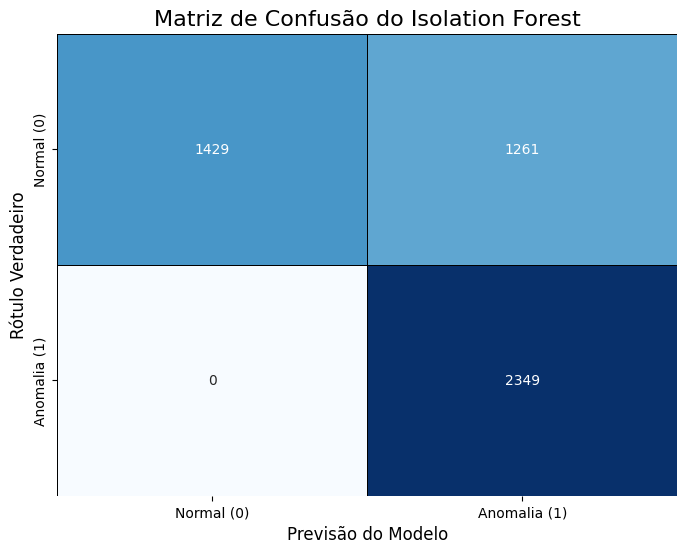

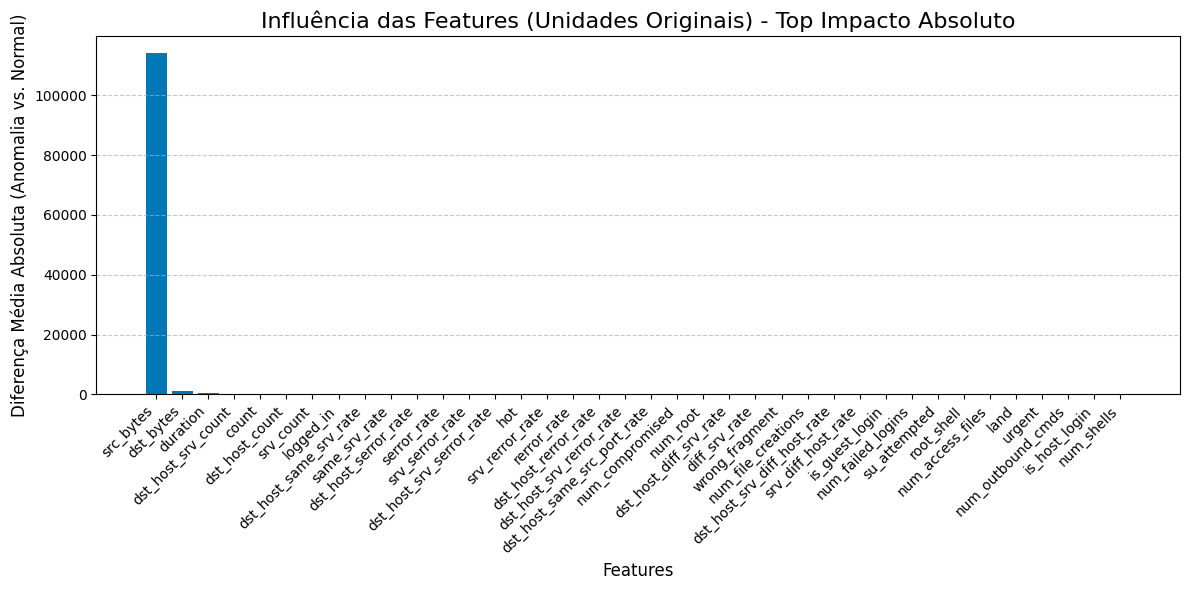

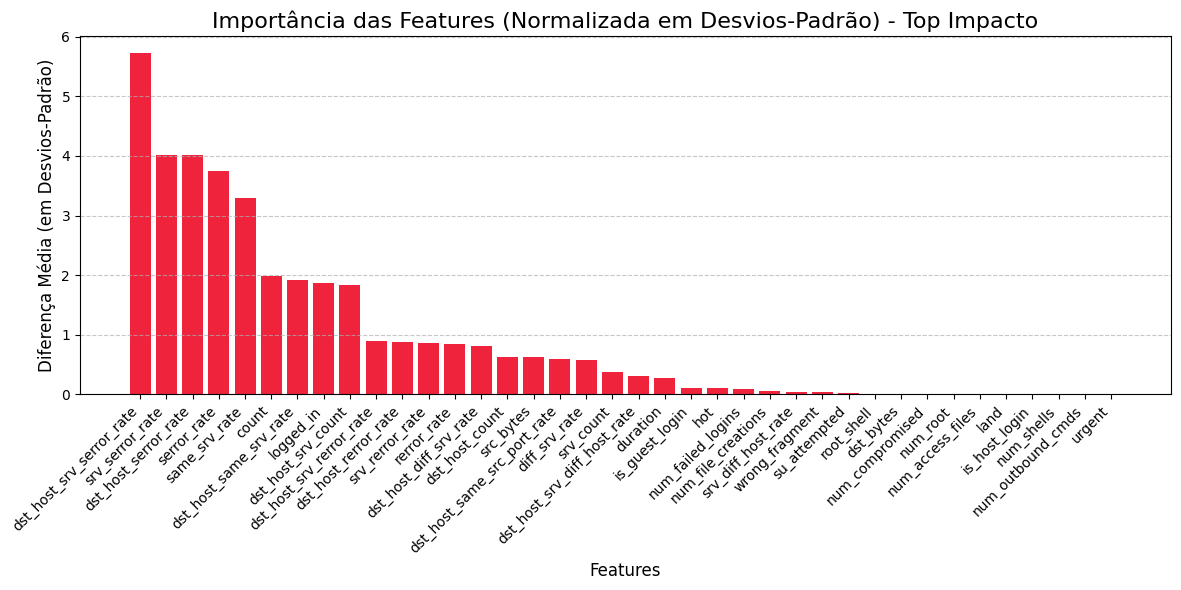


Análise Concluída.
A análise normalizada (segundo gráfico) é a mais relevante, pois mostra quais features
causam o maior 'desvio-padrão' e, portanto, foram mais importantes para o Isolation Forest isolar as anomalias.


In [98]:
# Nota: Este código assume que X_test, y_test, y_pred, model e a lista 'numericas' 
# (das features numéricas) estão definidos e vêm da execução da seção de treinamento.

# ============================================================
# 8. Análise dos resultados do modelo e Visualização
# ============================================================

# --- 8.1 Visualização da Matriz de Confusão ---

# Labels para o gráfico (0: Normal, 1: Anomalia)
labels = ['Normal (0)', 'Anomalia (1)']

# Calcula a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    cbar=False,
    xticklabels=labels, 
    yticklabels=labels,
    linewidths=.5,
    linecolor='black'
)
plt.title('Matriz de Confusão do Isolation Forest', fontsize=16)
plt.ylabel('Rótulo Verdadeiro', fontsize=12)
plt.xlabel('Previsão do Modelo', fontsize=12)
plt.show()


# --- 8.2 Análise das Features Mais Impactantes ---

# Copia apenas as features de teste
df_result_raw = X_test.copy()

# Mantém somente colunas numéricas (para análise de impacto em iForest, que usa StandardScaler)
df_result_raw = df_result_raw.select_dtypes(include=["number"])

# Adiciona a previsão do modelo
df_result_raw["Predito"] = y_pred

# Calcula a média das features por classe prevista (Normal/Anomalia)
feature_diff_raw = df_result_raw.groupby("Predito").mean().T

# Calcula a diferença absoluta entre a média das anomalias (Predito=1) e a média dos normais (Predito=0)
# A anomalia é definida por uma grande diferença em relação ao comportamento normal.
diff_raw = feature_diff_raw[1] - feature_diff_raw[0]

# O Isolation Forest utiliza o StandardScaler para a maioria das features numéricas.
# Para obter a importância real (em desvios-padrão), precisamos usar os parâmetros de escala
# que foram ajustados durante o treinamento (apenas em dados normais).
try:
    # 1. Obter o StandardScaler que foi treinado
    # O StandardScaler é o transformador 'num' dentro do ColumnTransformer 'prep' na Pipeline 'model'
    scaler = model["prep"].named_transformers_["num"]
    
    # 2. Obter os desvios-padrão (scale_) usados para normalização
    # É crucial garantir que a ordem dos desvios-padrão corresponda à ordem das colunas em 'numericas'
    std_devs = pd.Series(scaler.scale_, index=numericas)
    
    # 3. Calcular a diferença normalizada: (Média Anomalia - Média Normal) / Desvio Padrão
    # Isso mostra o impacto de cada feature em termos de desvios-padrão
    diff_scaled = diff_raw / std_devs
    
except KeyError as e:
    print(f"\nERRO: Não foi possível extrair o StandardScaler para calcular o impacto normalizado: {e}")
    print("Certifique-se de que a Pipeline e o ColumnTransformer estão nomeados corretamente ('prep' e 'num').")
    diff_scaled = diff_raw # Fallback: usa a diferença raw se houver erro

# --- 8.3 Gráfico de Features (Diferença Raw - Unidades Originais) ---
plt.figure(figsize=(12, 6))
# Mostrar o valor absoluto da diferença para focar no impacto
diff_raw_sorted = diff_raw.abs().sort_values(ascending=False)
plt.bar(diff_raw_sorted.index, diff_raw_sorted.values, color='#0077b6')
plt.title('Influência das Features (Unidades Originais) - Top Impacto Absoluto', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Diferença Média Absoluta (Anomalia vs. Normal)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# --- 8.4 Gráfico de Features (Diferença Normalizada - Desvios-Padrão) ---
plt.figure(figsize=(12, 6))
# Mostrar o valor absoluto da diferença normalizada, que representa a importância no modelo
diff_scaled_sorted = diff_scaled.abs().sort_values(ascending=False)
plt.bar(diff_scaled_sorted.index, diff_scaled_sorted.values, color='#ef233c')
plt.title('Importância das Features (Normalizada em Desvios-Padrão) - Top Impacto', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Diferença Média (em Desvios-Padrão)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nAnálise Concluída.")
print("A análise normalizada (segundo gráfico) é a mais relevante, pois mostra quais features")
print("causam o maior 'desvio-padrão' e, portanto, foram mais importantes para o Isolation Forest isolar as anomalias.")


### Observação:
- O primeiro gráfico mostra as diferenças absolutas nas unidades originais das features.
- O segundo gráfico mostra as diferenças relativas (dados padronizados).
- Normalizamos no Isolation Forest para que todas as features tenham igual influência na detecção de anomalias, evitando que a escala de uma variável distorça o isolamento.
- A normalização evita que atributos com escala grande (ex.: bytes, tempo) dominem o resultado.
- Assim, o segundo gráfico costuma refletir melhor as features mais relevantes para a detecção de anomalias.